## Parameters to adjust

In [1]:
zero_band = 0.08
translate = 0.003
steering_coefficient = 0.18

## Load Images File

In [2]:
import csv
import numpy as np
import random
import os
import pandas as pd

list_images = list()
path = 'data'
with open(path + '\driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        center = row[0].strip()
        left = row[1].strip()
        right = row[2].strip()
        steering = float(row[3])
        throttle = float(row[4])
        brake = float(row[5])
        speed = float(row[6])

        if steering == 0:
            if (np.random.rand() <= zero_band):
                list_images.append([center, left, right, steering, throttle, brake, speed])
        else:
            list_images.append([center, left, right, steering, throttle, brake, speed])

### Ploting histogram

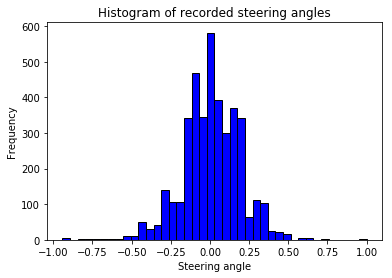

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

histogram = [x[3] for x in list_images]

plt.hist(histogram, bins = 40, facecolor='blue', edgecolor = "black");
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

## Image Augmentation

In [4]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random

def flip_image(img, steering):
    if random.randint(0, 1):
        return cv2.flip(img, 1), -steering
    else:
        return img, steering

def brightness_image(img, steering):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * (1 + np.random.uniform(-0.6, 0.2))
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), steering

def rotate_image(img, steering):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-3, 3), 1)
    return cv2.warpAffine(img,M,(cols,rows), borderMode=1), steering

def cut_image(img):
    return img[60:136, :, :]

def translate_image(img, steering, horz_range=30, vert_range=5):
    rows, cols, chs = img.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * translate # mul by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    img = cv2.warpAffine(img, tr_M, (cols,rows), borderMode=1)
    return img, steering

def shadow_image(img, steering):
    rows, cols, chs = img.shape
    
    # Generate a separate buffer
    shadows = img.copy()

    randomUp = int(random.random() * cols)
    randomDown = int(random.random() * cols)
    
    if random.randint(0, 1):
        poly = [[randomUp,0],[cols,0],[cols,rows], [randomDown,rows]]
    else:
        poly = [[randomUp,0],[0,0],[0,rows], [randomDown,0]]
        
    cv2.fillPoly(shadows, np.array([poly]), -1)

    alpha = np.random.uniform(0.6, 0.9)
    return cv2.addWeighted(shadows, alpha, img, 1-alpha,0,img), steering

def shear_image(image, steering_angle, shear_range=200):
    if random.randint(0, 1):
        rows, cols, ch = image.shape
        dx = np.random.randint(-shear_range, shear_range + 1)
        random_point = [cols / 2 + dx, rows / 2]
        pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
        pts2 = np.float32([[0, rows], [cols, rows], random_point])
        dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
        steering_angle += dsteering

    return image, steering_angle

## Neural network implementation
Bellow will be implemented the CNN, which is based on [CommaAI](https://github.com/commaai/research/blob/master/train_steering_model.py) algorithm.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Activation, MaxPooling2D, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

# Input layer shape
ch, row, col = 3, 64, 64

def model_nv():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(col,row,ch),
            output_shape=(col,row,ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Activation('relu'))
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    return model

def model_comma():
    init = 'normal'
    input_shape=(col, row, ch)

    model = Sequential()

    model.add(Lambda(lambda x: x/255.-0.5, input_shape=input_shape))

    model.add(Convolution2D(16, 3, 3, border_mode='valid', init=init))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(32, 3, 3, border_mode='valid', init=init))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Convolution2D(48, 3, 3, border_mode='valid', init=init))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(256, init=init))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, init=init))
    model.add(Activation('elu'))

    model.add(Dense(16, init=init))
    model.add(Activation('elu'))

    model.add(Dense(1, init=init))
    return model

model = model_comma()
print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 62, 62, 16)    448         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 62, 62, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 16)    0           activation_1[0][0]               
___________________________________________________________________________________________

## Training and validation split

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle list
list_images = shuffle(list_images)

# Split testing set
train_set, valid_set = train_test_split(list_images, test_size=0.3, random_state=0)

print("Train set =", len(train_set))
print("Validation set =", len(valid_set))

Train set = 2805
Validation set = 1203


## Load the data
Function to load the data given a list of images and the indices that need to be loaded. The data is only load to the memory when the generator asks.

In [7]:
import matplotlib.image as mpimg

def load_data_batch(data, indices):
    # Placeholders for the images and labels from web
    X = list()
    y = list()

    for i in indices:
        rnd = np.random.randint(0, 3)
        image = plt.imread(path + "\\" + data[i][rnd])
        steering = data[i][3]
        
        if rnd == 1:
            steering += steering_coefficient
        elif rnd == 2:
            steering -= steering_coefficient

        X.append(image)
        y.append(steering)

    return X, y

## Generator function
Return the images and steering values needed to the batch.

In [ ]:
def myGenerator(samples, batch_size, augment=True):
    while True:
        X_batch = []
        y_batch = []
        
        indices = np.random.randint(0, len(samples), batch_size)
        
        X, y = load_data_batch(samples, indices)

        for i in range(batch_size):
            image = X[i]
            angle = y[i]
            
            if augment:
                image, angle = shear_image(image, angle)
                image, angle = shear_image(image, angle)
                image, angle = brightness_image(image, angle)
                image, angle = translate_image(image, angle)
                image, angle = rotate_image(image, angle)
                image, angle = shadow_image(image, angle)
                image, angle = flip_image(image, angle)
            
            image = cut_image(image)
            image = cv2.resize(image,(64, 64), interpolation = cv2.INTER_AREA)

            X_batch.append(image)
            y_batch.append(angle)

        yield np.array(X_batch), np.array(y_batch)

## Neural network training

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-4))

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='model.weights.{epoch:02d}-{val_loss:.5f}.h5', verbose=1, save_best_only=True, save_weights_only=True)
learning_rate_plateau_reducer = ReduceLROnPlateau(verbose=1, patience=2, epsilon=1e-5)

batch_size= 50
samples_epoch_test = 20000
samples_epoch_validation = 6000
n_epoch = 7

fit = model.fit_generator(myGenerator(train_set, batch_size),
                          verbose=1, samples_per_epoch=samples_epoch_test,
                          nb_epoch=n_epoch,
                          callbacks=[learning_rate_plateau_reducer, early_stopping,model_checkpoint],
                          validation_data=myGenerator(valid_set, batch_size),
                          nb_val_samples = samples_epoch_validation)

Epoch 1/7
20000/20000 [==============================] - 221s - loss: 0.3258 - val_loss: 0.2494
Epoch 2/7
20000/20000 [==============================] - 198s - loss: 0.2176 - val_loss: 0.1825
Epoch 3/7
20000/20000 [==============================] - 195s - loss: 0.1757 - val_loss: 0.1640
Epoch 4/7
 2050/20000 [==>...........................] - ETA: 120s - loss: 0.1701

## Save model

In [ ]:
import json

model_json = model.to_json()
with open ('model.json', 'w') as f:
    json.dump(model_json, f, indent=4, sort_keys=True, separators=(',', ':'))

model.save_weights('model.h5')

print("Model Saved!")